In [75]:
from enum import auto
from dateutil.parser import parse 
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(1)
import pandas as pd


from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

import tensorflow as tf 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


# Import as Dataframe
stock = pd.read_csv('Stock_prices.csv')
stock.head()

,Date,NTFLX_Open,NTFLX_High,NTFLX_Low,NTFLX_Close,NTFLX_Volume,NSDQ_Open,NSDQ_High,NSDQ_Low,NSDQ_Close,NSDQ_Volume,Unemployment_rate,Interest_Rate
0,2016-11-28,117.050003,117.620003,115.709999,116.930000,5278900,5387.919922,5396.270020,5364.910156,5368.810059,1625620000,4.7,0.41
1,2016-11-29,117.300003,119.180000,117.129997,117.510002,7082300,5370.979980,5403.859863,5360.560059,5379.919922,1788790000,4.7,0.41
2,2016-11-30,119.000000,120.370003,116.389999,117.000000,7715100,5391.350098,5393.149902,5323.680176,5323.680176,2064430000,4.7,0.41
3,2016-12-01,117.519997,118.680000,113.949997,117.220001,8636900,5323.879883,5326.339844,5238.209961,5251.109863,2264960000,4.7,0.54
4,2016-12-02,116.750000,120.980003,116.750000,120.809998,8953600,5249.020020,5274.540039,5239.270020,5255.649902,1848930000,4.7,0.54


In [2]:
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from pylab import rcParams


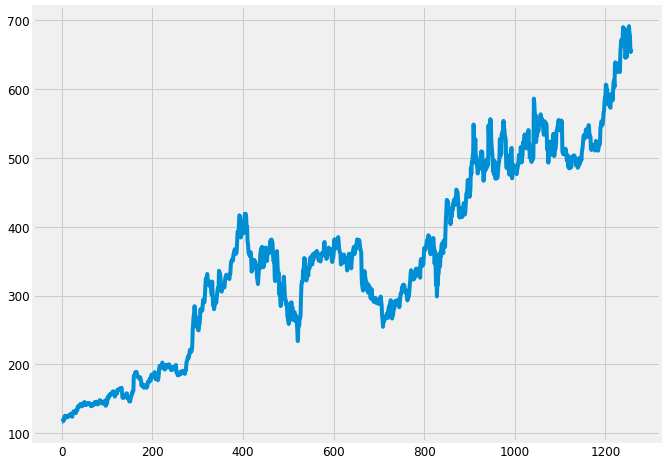

In [3]:
plt.figure(figsize=(10, 8))
stock['NTFLX_Close'].plot()
plt.show()

In [4]:
stock.corr()

,NTFLX_Open,NTFLX_High,NTFLX_Low,NTFLX_Close,NTFLX_Volume,NSDQ_Open,NSDQ_High,NSDQ_Low,NSDQ_Close,NSDQ_Volume,Unemployment_rate,Interest_Rate
NTFLX_Open,1.000000,0.999336,0.999322,0.998557,-0.196311,0.918089,0.919638,0.916100,0.917614,0.757371,0.386655,-0.467861
NTFLX_High,0.999336,1.000000,0.999142,0.999361,-0.184197,0.915624,0.917503,0.913723,0.915483,0.758254,0.389379,-0.467202
NTFLX_Low,0.999322,0.999142,1.000000,0.999330,-0.208052,0.921089,0.922714,0.919695,0.921150,0.754511,0.384246,-0.470232
NTFLX_Close,0.998557,0.999361,0.999330,1.000000,-0.194350,0.917919,0.919864,0.916546,0.918482,0.755016,0.387618,-0.468838
NTFLX_Volume,-0.196311,-0.184197,-0.208052,-0.194350,1.000000,-0.335235,-0.333014,-0.338570,-0.335978,-0.229584,-0.090503,0.358209
NSDQ_Open,0.918089,0.915624,0.921089,0.917919,-0.335235,1.000000,0.999819,0.999680,0.999509,0.788386,0.304595,-0.628332
NSDQ_High,0.919638,0.917503,0.922714,0.919864,-0.333014,0.999819,1.000000,0.999583,0.999704,0.791346,0.307945,-0.629795
NSDQ_Low,0.916100,0.913723,0.919695,0.916546,-0.338570,0.999680,0.999583,1.000000,0.999756,0.782645,0.301143,-0.626864
NSDQ_Close,0.917614,0.915483,0.921150,0.918482,-0.335978,0.999509,0.999704,0.999756,1.000000,0.786499,0.305124,-0.628602
NSDQ_Volume,0.757371,0.758254,0.754511,0.755016,-0.229584,0.788386,0.791346,0.782645,0.786499,1.000000,0.489135,-0.676067


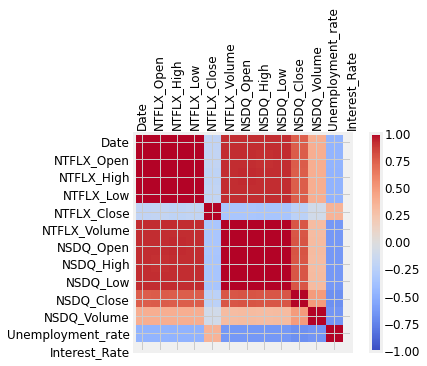

In [5]:

corr = stock.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(stock.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(stock.columns)
ax.set_yticklabels(stock.columns)
plt.show()

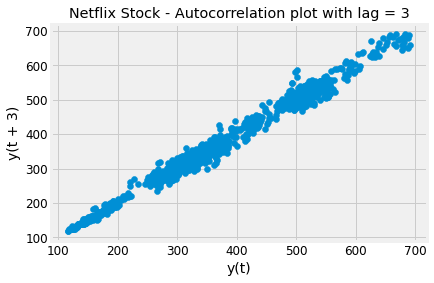

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

plt.figure()
lag_plot(stock['NTFLX_Close'], lag=3)
plt.title('Netflix Stock - Autocorrelation plot with lag = 3')
plt.show()

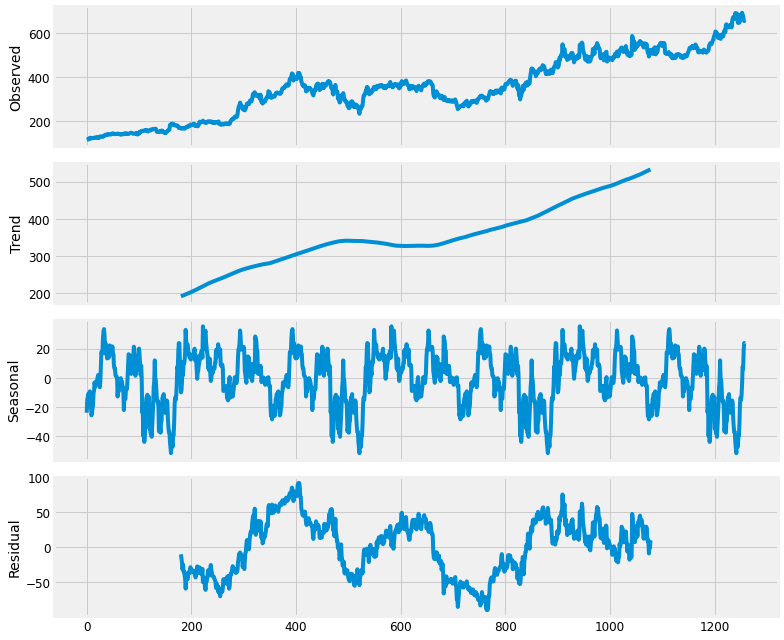

In [7]:
# Now, for decomposition...
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 11, 9
decomposed_NTFLX_volume = sm.tsa.seasonal_decompose(stock["NTFLX_Close"],freq=360) # The frequncy is annual
figure = decomposed_NTFLX_volume.plot()
plt.show()

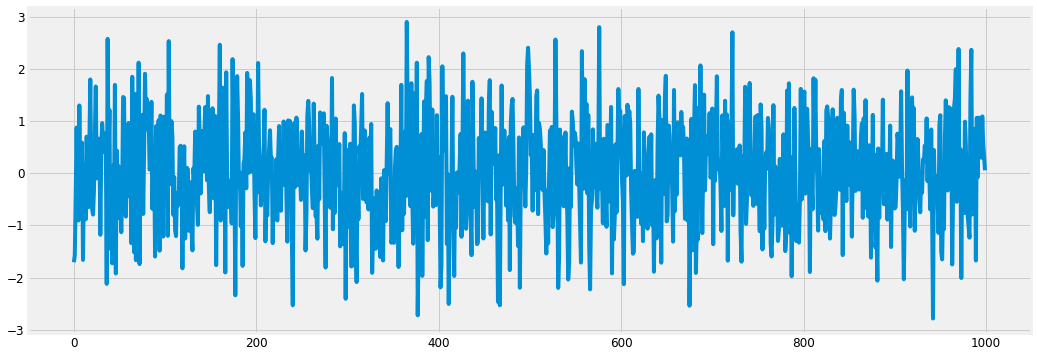

In [8]:
# Plotting white noise
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

In [9]:
# Augmented Dickey-Fuller test on volume of google and microsoft stocks 
adf = adfuller(stock["NTFLX_Close"])
print("p-value of Netflix: {}".format(float(adf[1])))

p-value of Netflix: 0.9383522042667436


Netflix has p-value 0.9383522042667436 which is more than 0.05, null hypothesis is rejected and this is not a random walk.

In [35]:
# Change date column to datetime type
stock['Date'] = pd.to_datetime(stock['Date'])

In [36]:
series = stock['NTFLX_Close']

# Create train data set
train_split_date = '2018-12-31'
train_split_index = np.where(stock.Date == train_split_date)[0][0]
x_train = stock.loc[stock['Date'] <= train_split_date]['NTFLX_Close']

# Create test data set
test_split_date = '2019-05-02'
test_split_index = np.where(stock.Date == test_split_date)[0][0]
x_test = stock.loc[stock['Date'] >= test_split_date]['NTFLX_Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = stock.loc[(stock['Date'] < test_split_date) & (stock['Date'] > train_split_date)]['NTFLX_Close']

525 526 608 609 1257


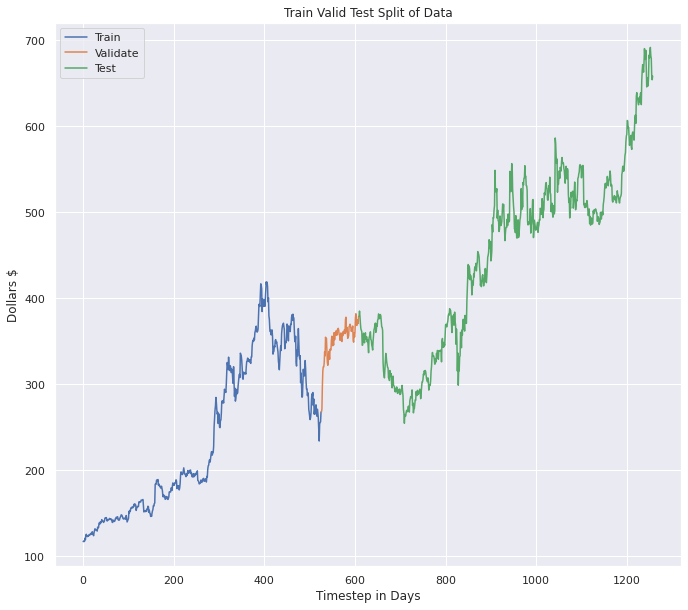

In [37]:
# set style of charts
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [38]:
stock['LogReturn'] = np.log(stock['NTFLX_Close']).shift(-1) - np.log(stock['NTFLX_Close'])
print(stock['LogReturn'])

0       0.004948
1      -0.004350
2       0.001879
3       0.030167
4      -0.013752
          ...   
1253   -0.004732
1254   -0.029300
1255   -0.007828
1256    0.006446
1257         NaN
Name: LogReturn, Length: 1258, dtype: float64


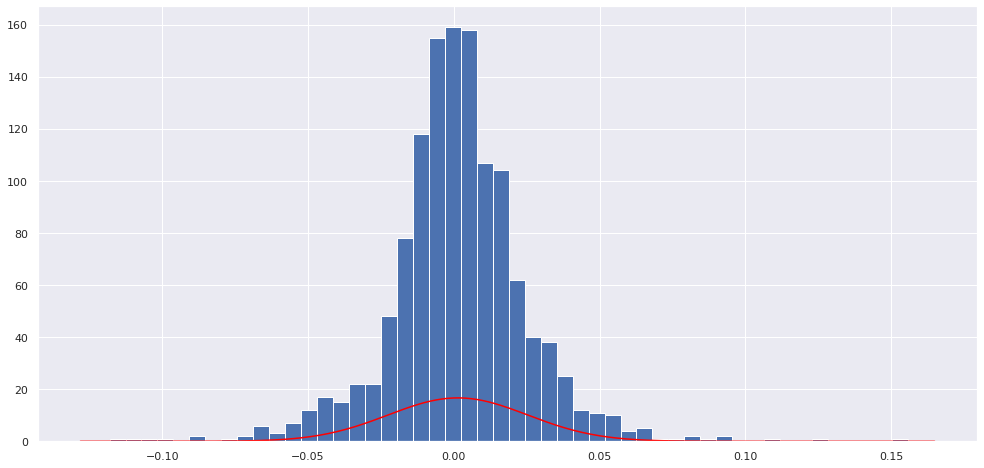

In [39]:
from scipy.stats import norm
mu = stock['LogReturn'].mean()
sigma = stock['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(stock['LogReturn'].min()-0.01, stock['LogReturn'].max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

stock['LogReturn'].hist(bins=50, figsize=(15, 8))
plt.plot(density['x'], density['pdf'], color='red')
plt.show()

In [40]:
prob_return1 = norm.cdf(-0.10, mu, sigma)
print('The probability of dropping over 10% in one day ', prob_return1)

The probability of dropping over 10% in one day  1.1399099344341717e-05


In [41]:
VaR = norm.ppf(0.05, mu, sigma)
print('Single day value at risk is: ', VaR)

Single day value at risk is:  -0.0379934973790773


In [42]:
mu220 = 365*mu
sigma220 = (365**0.5) * sigma
drop20 = None
print('The probability of dropping over 25% over a year: ', drop20)

The probability of dropping over 25% over a year:  None


In [43]:
# Quatile 
# 5% quantile
print('5% quantile ', norm.ppf(0.05, mu, sigma))
# 95% quantile
print('95% quantile ', norm.ppf(0.95, mu, sigma))

5% quantile  -0.0379934973790773
95% quantile  0.040743012200308376


In [44]:
stock['logReturn'] = np.log(stock['NTFLX_Close'].shift(-1)) - np.log(stock['NTFLX_Close'])
sample_size = stock['logReturn'].shape[0]
sample_mean = stock['logReturn'].mean()
sample_std = stock['logReturn'].std(ddof=1) / sample_size**0.5
# left and right quantile
z_left = norm.ppf(0.05)
z_right = norm.ppf(0.95)

# upper and lower bound
interval_left = sample_mean+z_left*sample_std
interval_right = sample_mean+z_right*sample_std

In [45]:
print('90% confidence interval is ', (interval_left, interval_right))

90% confidence interval is  (0.0002648012085885165, 0.00248471361264257)


Moving Average (MA) Model - 

In [46]:
from statsmodels.tsa.arima_model import ARMA

ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1450.367
Method:                       css-mle   S.D. of innovations              1.031
Date:                Sun, 19 Dec 2021   AIC                           2906.734
Time:                        22:40:23   BIC                           2921.457
Sample:                             0   HQIC                          2912.330
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4323      0.282      1.534      0.125      -0.120       0.985
ar.L1.y        0.8852      0.015     60.266      0.000       0.856       0.914
                                    Roots           

In [105]:
mse_MA50 = math.sqrt(mean_squared_error(stock["NTFLX_Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The mean squared error is {}.".format(mse_MA50))

The mean squared error is 25.023908182964778.


In [48]:
stock['PriceDiff'] = stock['NTFLX_Close'].shift(-1) - stock['NTFLX_Close']

print(stock['PriceDiff'])

0        0.580002
1       -0.510002
2        0.220001
3        3.589997
4       -1.649994
          ...    
1253    -3.220032
1254   -19.599976
1255    -5.140014
1256     4.229980
1257          NaN
Name: PriceDiff, Length: 1258, dtype: float64


In [49]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


In [50]:
# Choose a window size for the moving average
window = 50

# Create a moving average over the entire dataset
moving_avg = stock['NTFLX_Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:stock.index.max() - window + 1]

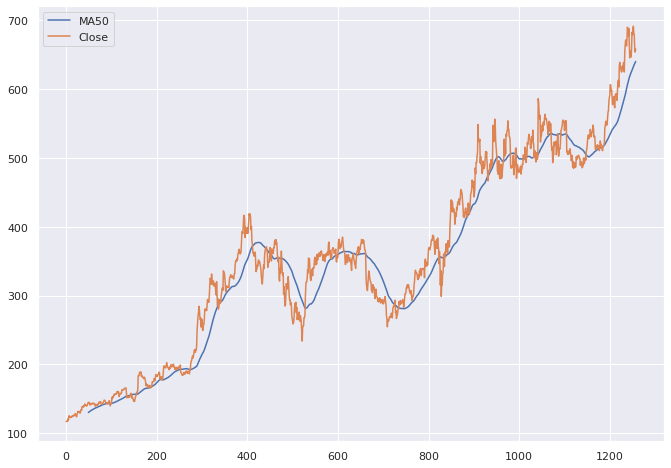

In [51]:
stock['ma50'] = stock['NTFLX_Close'].rolling(50).mean()
#plot the moving average
plt.figure(figsize=(10, 8))
stock['ma50'].plot(label='MA50')
stock['NTFLX_Close'].plot(label='Close')
plt.legend()
plt.show()

In [30]:
# Lets create a dictionary to store all of our model training scores to view later
model_mse_scores = {}

In [52]:
# Save to our dictionary of model mae scores
model_mse_scores['MA_50'] = mse_MA50
model_mse_scores

{'MA_50': 13.336592449816626}

In [ ]:
#Using different models 

ARIMA Model 

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
NTFLX_arima = ARIMA(x_train, order=(4,2,0))
NTFLX_arima_fit = NTFLX_arima.fit(disp=0)
print(NTFLX_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.NTFLX_Close   No. Observations:                  524
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1783.295
Method:                       css-mle   S.D. of innovations              7.268
Date:                Sun, 19 Dec 2021   AIC                           3578.590
Time:                        22:41:11   BIC                           3604.159
Sample:                             2   HQIC                          3588.603
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0118      0.116      0.102      0.919      -0.215       0.239
ar.L1.D2.NTFLX_Close    -0.8100      0.044    -18.566      0.000      -0.895      -0.724
ar.L2.D2.NTF

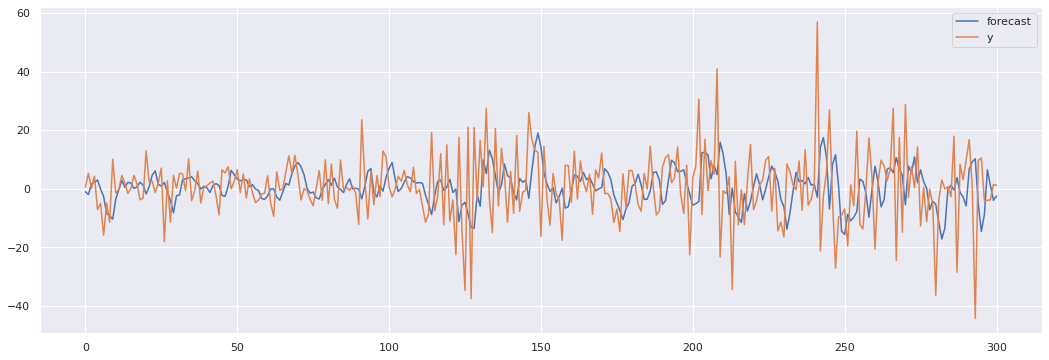

In [54]:
rcParams['figure.figsize'] = 16, 6
model = ARIMA(stock["NTFLX_Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
result.plot_predict(start=700, end=1000)
plt.show()

In [55]:
mse_ARIMA = math.sqrt(mean_squared_error(stock["NTFLX_Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The mean squared error is {}.".format(rmse))

The mean squared error is 25.023908182964778.


In [56]:
model_mse_scores['ARIMA'] = mse_ARIMA
model_mse_scores

{'ARIMA': 21.567996250030234, 'MA_50': 13.336592449816626}

NormaltestResult(statistic=37.66581251663065, pvalue=6.621749292554914e-09)
This distribution is not a normal distribution


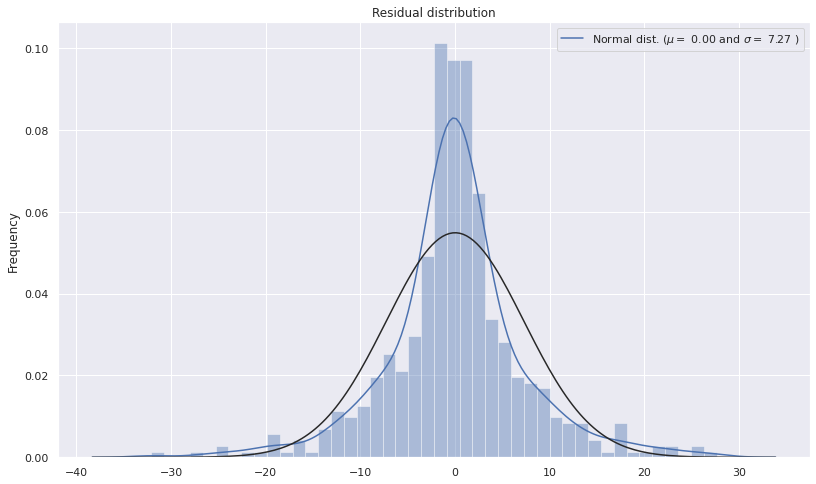

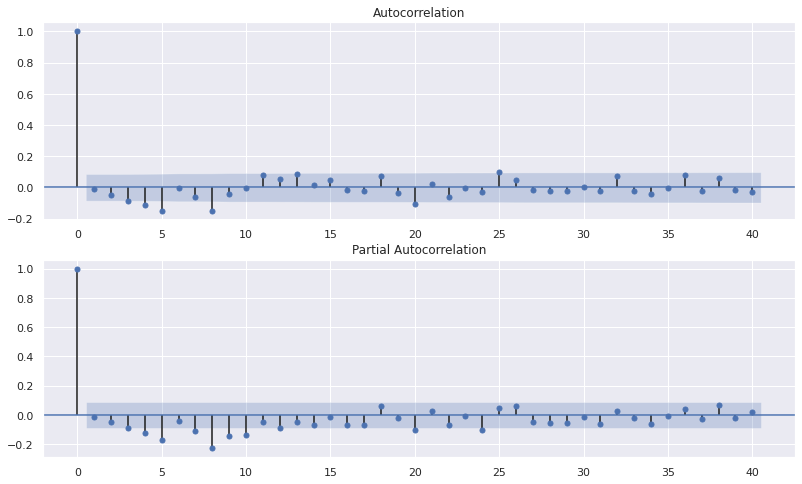

In [57]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = NTFLX_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [58]:
# Begin building model. First, create list of x train valuess

import tensorflow as tf

keras = tf.keras

history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-652:]):
    model = ARIMA(history, order=(4,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is [175.97117376 100.57077643  98.42403419  98.0405211   99.3530303
 110.71619522 116.29354998 117.09099206 126.77109584 125.02688582
 118.56077428 116.28306849 117.67674408 120.8274183  117.56597996
 115.41320109 119.96319365 117.2905666  117.33666144 122.07307281
 119.44696471 125.46663021 130.40107899 117.87405642 117.32020172
 115.66617557 112.57096735 118.92251455 119.86901337 124.10400328
 126.00841723 128.05111207 119.92731011 115.82281774 112.05917904
 110.87961358 109.62308075 109.5260945  115.53621668 114.39063997
 110.9288506  112.81764298 108.64557959 108.29606856 106.38693006
 106.88151898 108.79409526 107.40026823 107.48471618 108.14992488
 110.39351773 113.65487835 114.11081746 116.22088562 143.65798413
 150.0117489  154.78198917 158.54457234 143.00427641 133.10264285
 125.09714429 127.0270415  132.90842236 136.44924805 140.99785831
 141.64411789 151.27729752 147.47436875 153.00481127 141.47841435
 147.19271522 144.61902697 142.74721448 156.809

In [59]:
output

(array([645.4396047]),
 array([10.64704152]),
 array([[624.57178678, 666.30742263]]))

In [60]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[array([274.33296218]),
 array([406.97654484]),
 array([415.32338758]),
 array([416.9087379]),
 array([411.65297819])]

In [ ]:
model_predictions

[array([274.33296218]),
 array([406.97654484]),
 array([415.32338758]),
 array([416.9087379]),
 array([411.65297819]),
 array([371.30680874]),
 array([358.03496988]),
 array([356.35922034]),
 array([338.35129528]),
 array([341.37283258]),
 array([353.36736185]),
 array([358.05742032]),
 array([355.14839024]),
 array([348.98474025]),
 array([355.37659951]),
 array([359.92596082]),
 array([350.62895297]),
 array([355.94540604]),
 array([355.8498292]),
 array([346.6667964]),
 array([351.62522316]),
 array([340.60357621]),
 array([332.39298188]),
 array([354.7454144]),
 array([355.88395815]),
 array([359.37920887]),
 array([366.5110565]),
 array([352.6525164]),
 array([350.81032686]),
 array([342.99109432]),
 array([339.65628546]),
 array([336.20966436]),
 array([350.69805807]),
 array([359.04323795]),
 array([367.7811686]),
 array([370.85055144]),
 array([374.48068724]),
 array([374.76965242]),
 array([359.65941923]),
 array([362.20506826]),
 array([370.71575675]),
 array([365.91204304]),

In [61]:
model_predictions = np.array(model_predictions).flatten()

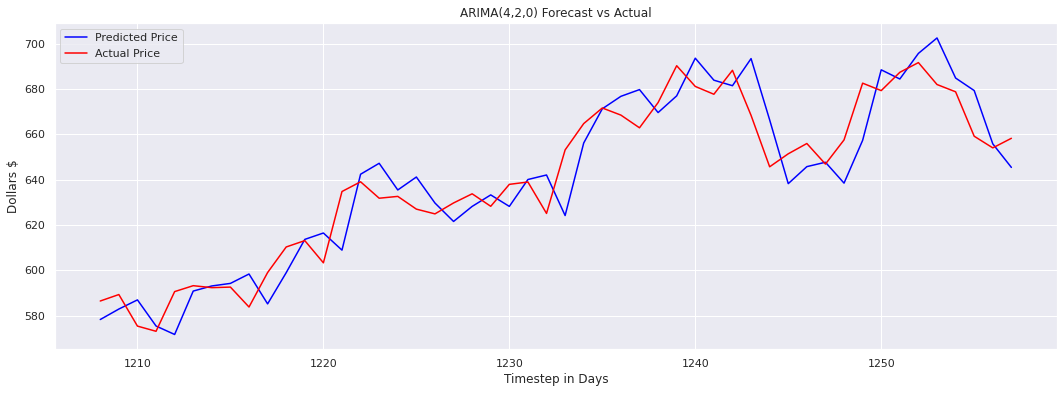

<Figure size 720x432 with 0 Axes>

In [62]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-50:], model_predictions[-50:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-50:], x_test[-50:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [63]:
# Find the Error in the ARIMA Model
model_predictions = np.squeeze(model_predictions)

arima_error = model_predictions - x_test

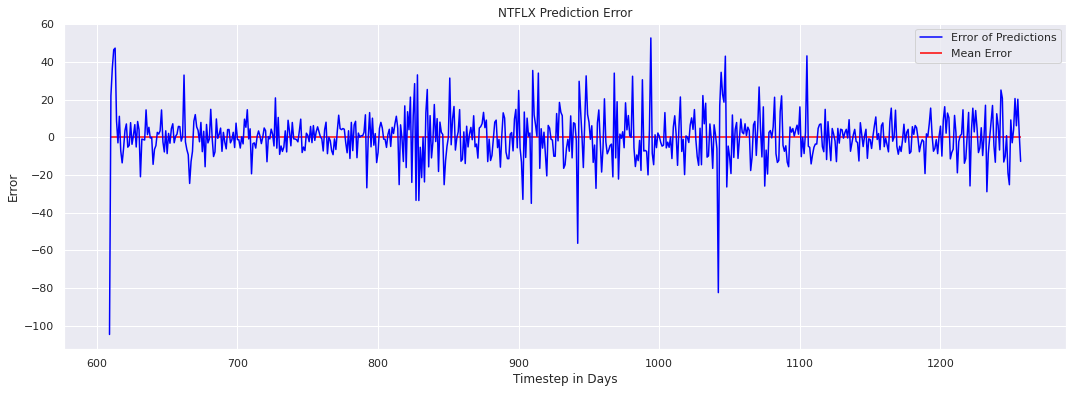

<Figure size 720x432 with 0 Axes>

In [64]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('NTFLX Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

LSTM Model

In [88]:
df = pd.read_csv(('Stock_prices.csv'),parse_dates = True,index_col=0)
df.tail()

,NTFLX_Open,NTFLX_High,NTFLX_Low,NTFLX_Close,NTFLX_Volume,NSDQ_Open,NSDQ_High,NSDQ_Low,NSDQ_Close,NSDQ_Volume,Unemployment_rate,Interest_Rate
Date,,,,,,,,,,,,
2021-11-18,691.609985,691.739990,679.739990,682.020020,2012900,15973.38965,16010.87988,15848.83008,15993.70996,5361690000,4.5,0.15
2021-11-19,692.349976,694.159973,675.000000,678.799988,2613700,16042.16016,16121.12012,16017.23047,16057.44043,4849160000,4.5,0.15
2021-11-22,676.020020,679.479980,656.469971,659.200012,2764400,16120.91992,16212.23047,15851.04004,15854.75977,5531070000,4.5,0.15
2021-11-23,658.179993,666.429993,646.049988,654.059998,2320200,15809.50000,15895.86035,15601.45996,15775.13965,5412610000,4.5,0.15
2021-11-24,658.010010,661.440002,651.099976,658.289978,1867300,15677.87988,15848.55957,15591.36035,15845.23047,4178630000,4.5,0.15


In [89]:
from keras.callbacks import EarlyStopping

# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [90]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [91]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [92]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [93]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [94]:
# Extracting the series
series = df[['NTFLX_Close','NTFLX_High','NTFLX_Low']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(1258, 3)
            NTFLX_Close  NTFLX_High   NTFLX_Low
Date                                           
2021-11-18   682.020020  691.739990  679.739990
2021-11-19   678.799988  694.159973  675.000000
2021-11-22   659.200012  679.479980  656.469971
2021-11-23   654.059998  666.429993  646.049988
2021-11-24   658.289978  661.440002  651.099976


In [95]:
import datetime as dt
import time

# Train Val Test Split
train_start = dt.date(2017,1,1)
train_end = dt.date(2018,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2019,1,1)
val_end = dt.date(2020,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2021,1,1)
test_end = dt.date(2021,11,22)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(502, 3) (505, 3) (225, 3)


In [96]:
#Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(502, 3) (505, 3) (225, 3)


In [97]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

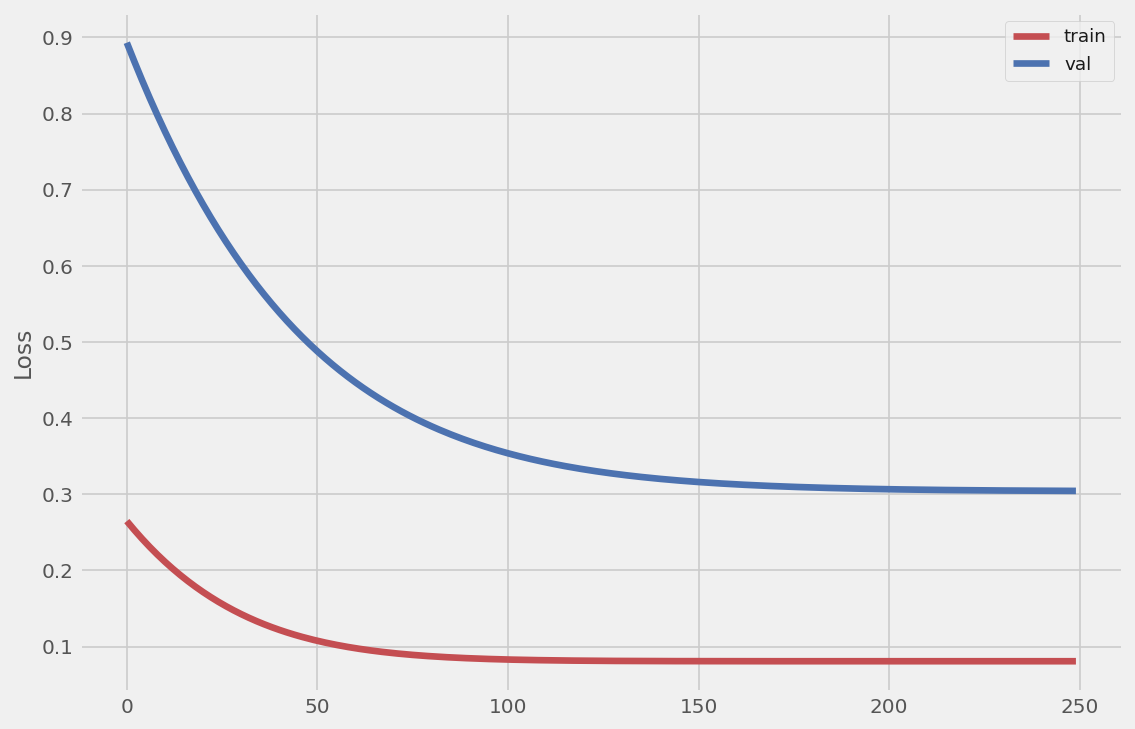

In [98]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 1.115325056594572
RMSE = 1.0560895116393174
R-Squared Score = -25.674119867579044


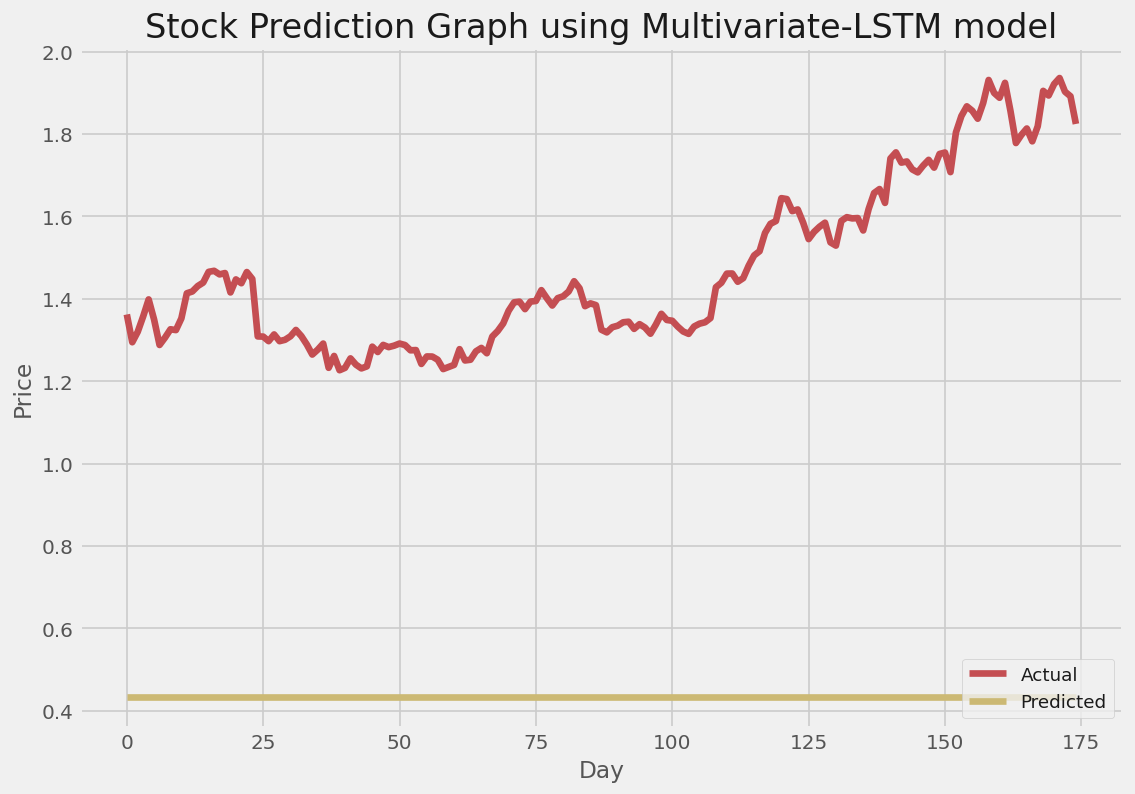

In [99]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)


In [100]:
model_mse_scores['LSTM'] = mse
model_mse_scores

{'ARIMA': 21.567996250030234,
 'LSTM': 1.115325056594572,
 'MA_50': 13.336592449816626}

To conclude, there is no risk in investing in the Netflix stock and if we were to use a model to forecast and predict stock prices, the LSTM model would be the most appropriate as it has the lowest MSE. 